## 1.  Imports

In [11]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger, LearningRateScheduler
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize

from skimage.transform import resize as imresize

%matplotlib inline

/jet/prs/workspace/ssd_keras/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


## 2. Check data

(1360, 800, 3)

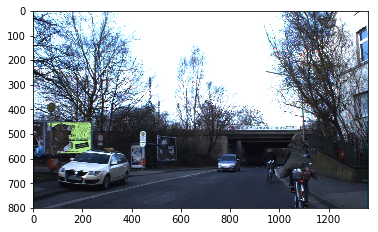

In [4]:
im = '00766.ppm'
path = '/home/jet/data/'
filename = path + im

images = []
with Image.open(filename) as image:
    images.append(np.array(image, dtype=np.uint8))

plt.imshow(images[0])

len(images[0][0]), len(images[0]), len(images[0][0][0])

In [5]:
img_height = 300 # Height of the model input images
img_width = 420 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 42 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
# scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
ym = 800 # Height of the sourse image
xm = 1360 # Width of the sourse image

## 2. Build / load the model

In [15]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# # TODO: Set the path to the weights you want to load.
weights_path = '/home/jet/data/weights/VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### 2.2 Load a saved model

In [6]:
model_path = 'ssd300_pascal_07+12_epoch-94_loss-2.9807_val_loss-3.0882.h5'

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

In [7]:
# model.save_weights('01_09_weights.h5')

## 3 Read labels

In [23]:
labels = pd.read_csv(path + 'gt.txt', delimiter=';',header=None)

labels.set_index(0, inplace=True)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=777)

for train_index, test_index in splitter.split(labels, labels[5]):
    d_train = labels.iloc[train_index]
    d_val = labels.iloc[test_index]
    
d_train.to_csv('/home/jet/data/train_labels.csv')
d_val.to_csv('/home/jet/data/val_labels.csv')
labels.to_csv('/home/jet/data/labels.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fceb2c3cef0>]],
      dtype=object)

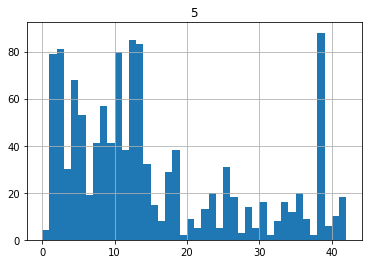

In [27]:
labels.hist(column=5,bins=42)

### 3.1 Load data into memory and make 2 datagenerator objects for training and validation

In [24]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.


train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.


# Images
images_dir = '/home/jet/data/'

# Ground truth
train_labels_filename = '/home/jet/data/train_labels.csv'
val_labels_filename   = '/home/jet/data/val_labels.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin',  'ymin', 'xmax','ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin',  'ymin', 'xmax','ymax', 'class_id'],
                      include_classes='all')

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 384/384 [00:24<00:00, 15.42it/s]
Number of images in the training dataset:	   549
Number of images in the validation dataset:	   384


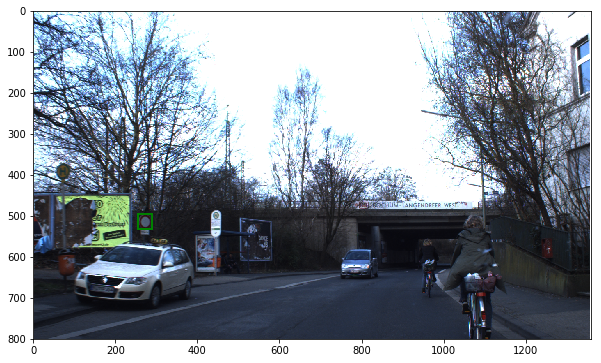

In [28]:
# Check bound_box

plt.figure(figsize=(10,7))
plt.imshow(images[0])

current_axis = plt.gca()

box = labels.loc[im]
xmin = box[1]
ymin = box[2]
xmax = box[3]
ymax = box[4]

current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  


In [29]:
# 3: Set the batch size.

batch_size = 32 

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   549
Number of images in the validation dataset:	   384


### 3.2 Check generator objects and label encoding

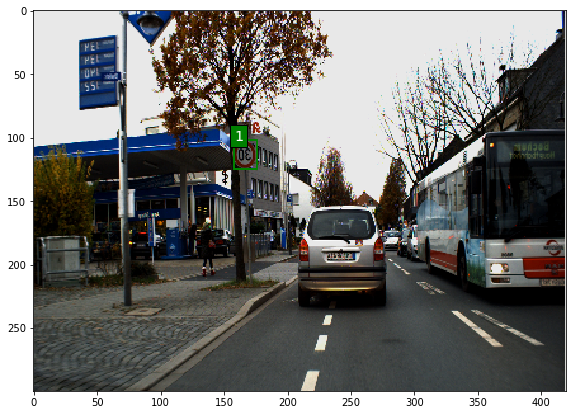

In [33]:
# Check the system

a,b = next(train_generator)

y_pred_decoded = decode_detections(b,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)


# 5: Draw the predicted boxes onto the image
i=0
plt.figure(figsize=(10,7))
plt.imshow(a[0])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() 
classes = np.arange(43)

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})



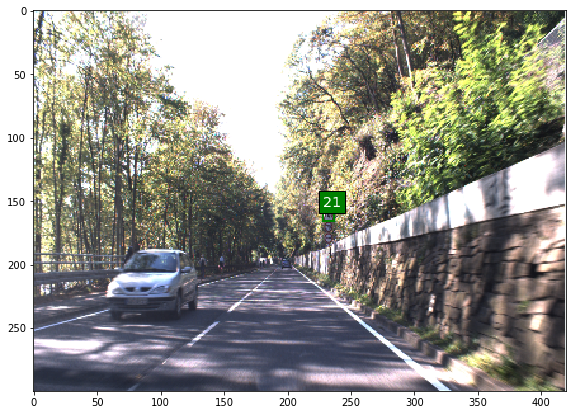

In [34]:
# Check the system

a,b = next(val_generator)

y_pred_decoded = decode_detections(b,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)


# 5: Draw the predicted boxes onto the image
i=0
plt.figure(figsize=(10,7))
plt.imshow(a[0])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() 
classes = np.arange(43) 
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})



## 4 Train the model

### 4.1 Set training parameters

In [38]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [39]:
# Define model callbacks.


model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)


csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

In [ ]:

initial_epoch   = 84
final_epoch     = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              verbose = 1,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 85/120

Epoch 00085: LearningRateScheduler setting learning rate to 0.0001.
 217/1000 [=====>........................] - ETA: 48:28 - loss: 3.2822

In [33]:
model.save('30_08-300.h5')

Let's look at how the training and validation loss evolved to check whether our training is going in the right direction:

### 5. Make predictions


In [43]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [44]:
# 2: Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /home/jet/data/00054.ppm

Ground truth boxes:

[[ 12 301 166 309 175]
 [ 38 141 195 147 202]]


All input images has shape 1360x800. My model takes 480x300 image as an input. Because of this I made two diffferent predictions for each image:
1. Cut image onto 4 parts with 1/40 overlap and make predictions for each (resized). After that, compile the whole prediction.
2. Make prediction for initial resized image.

Results are different and I cant say which one is better. I have measured only one of them


In [58]:
for im in batch_filenames:
    images = []
    with Image.open(im) as image:
        images.append(np.array(image, dtype=np.uint8))
    im = images[0] 
    y0x0 = im[0:int(ym/2+ym/40),0:int(xm/2+xm/40)]
    y1x0 = im[int(ym/2-ym/40):,0:int(xm/2+xm/40)]
    y0x1 = im[0:int(ym/2+ym/40),int(xm/2-xm/40):]
    y1x1 = im[int(ym/2-ym/40):,int(xm/2-xm/40):]
    im_arr = [y0x0, y1x0, y0x1, y1x1]
    decode = []
    for crop in im_arr:
        crop = imresize(crop, (img_height, img_width, 3), preserve_range=True).astype('uint8')
        y_pred = model.predict(np.asarray([crop]))
        y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.4,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)
        decode.append(y_pred_decoded)

/jet/var/python/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/jet/var/python/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [59]:
good_decode = []
for row in decode[0]:
    for pred in row:
        good_decode.append([pred[0], pred[1], pred[2], pred[3], pred[4], pred[5]])
for row in decode[1]:
    for pred in row:
        good_decode.append([pred[0], pred[1], pred[2], pred[3]+271, pred[4], pred[5]+271])
for row in decode[2]:
    for pred in row:
        good_decode.append([pred[0], pred[1], pred[2] + 380, pred[3], pred[4] + 380, pred[5]])
for row in decode[3]:
    for pred in row:
        good_decode.append([pred[0], pred[1], pred[2] + 380, pred[3]+271, pred[4] + 380, pred[5]+271])
for row in range(len(good_decode)):
    good_decode[row][3] *= 420/300
    good_decode[row][5] *= 420/300
    good_decode[row][2] *= 714/420
    good_decode[row][4] *= 714/420
for row in range(len(batch_labels[0])):
    batch_labels[0][row][1] *= 1360/420
    batch_labels[0][row][2] *= 800/300
    batch_labels[0][row][3] *= 1360/420
    batch_labels[0][row][4] *= 800/300
# good_decode = decode[0] + decode[1] + decode[2] + decode[3]

First method (4 predictions for 1 image)

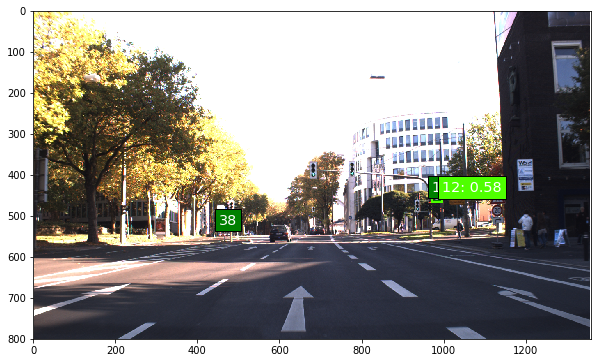

In [62]:
# # 5: Draw the predicted boxes onto the image

plt.figure(figsize=(10,7))
plt.imshow(im)

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = np.arange(43) # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in good_decode:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmax, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [63]:
y_pred = model.predict(batch_images)

# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.2,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [64]:
for row in range(len(batch_labels[0])):
    batch_labels[0][row][1] *= 420/1360
    batch_labels[0][row][2] *= 300/800
    batch_labels[0][row][3] *= 420/1360
    batch_labels[0][row][4] *= 300/800

Second method: one prediction

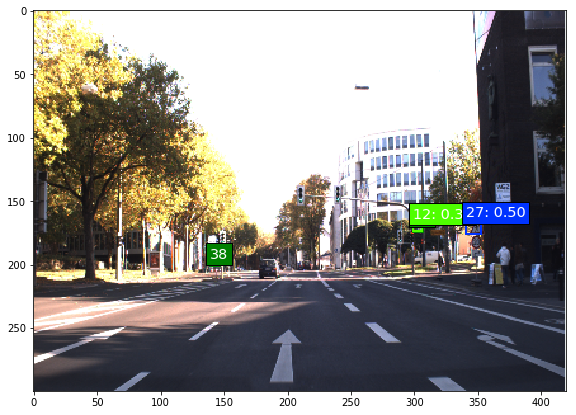

In [65]:
# # 5: Draw the predicted boxes onto the image

plt.figure(figsize=(10,7))
plt.imshow(batch_images[0])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = np.arange(43) # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})